In [1]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import os.path
from os import path

In [2]:
np.random.seed(42)
torch.manual_seed(42)

This notebook provides an implementation of CVRP solver by using the Operations Research Tools (OR-Tools) [1] and the Reinforcement Learning (RL) framework proposed by Kool et. al (2019). The code produced in this notebook complements the project report (report.pdf). 

The RL implementation is based on the code available in [2], which is the implementation in python provided by Kool et. al (2019), of the RL framework proposed in [3].

The object bellow saves the problem capacity for each problem size. I've used the same values provided in [3]. This means that for all problems generated of size 10, each vehicle will have a capacity of 20, for all the problems generated with 20 nodes, each vehicle will have a capacity of 30, and so on.

In [3]:
CAPACITIES = {
    10: 20.,
    20: 30.,
    50: 40.,
    100: 50.
}

Lets declare some methods that will be used further in the notebook.

In [4]:
# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap from the specified input map
    """
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_solution(df_solution, nodes, depot):
    cmap = discrete_cmap(len(df_solution) + 2, 'nipy_spectral')

    fig, ax1 = plt.subplots(figsize = (10,10))
    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=20)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    qvs = []
    for i, v in enumerate(df_solution['vehicle_id'].unique()):
        color = cmap(len(df_solution) - i) # Invert to have in rainbow order

        a = df_solution[df_solution['vehicle_id'] == v]
        route_coords = nodes[(a.route.values[0])]
        xs = route_coords[:,1]
        ys = route_coords[:,0]
        plt.scatter(xs,ys, s = 30, color = color)
        #plot the arrows
        qv = plt.quiver(xs[:-1], ys[:-1], xs[1:] - xs[:-1],ys[1:] - ys[:-1], scale_units='xy', angles='xy', scale=1, color = color, \
                  label='R{}; c {}, d {}'.format(i, a['cum_demand'].values[0], round(a.distance.values[0],2)))

        qvs.append(qv)
    ax1.set_title('{} routes, total distance {:.2f}'.format(len(df_solution), df_solution.distance.sum()))
    ax1.legend(handles=qvs)
    
metrics = ['mean','std','min','max']

def extract_metrics(model_name,time,df_solution):
    stats = df_solution.describe().iloc[1:4,:3].append(df_solution.describe().iloc[-1,:3])
    cols, data = stats.columns, {}
    data['model'] = model_name
    data['time'] = time
    data['distance'] = df_solution.distance.sum()
    for m in metrics:
        for c in cols: data['{}_{}'.format(c,m)] = round(stats.loc[m, c],3)
    return data

# Generate random CVRP problem instance

The method bellow generates random CVRP problem instances **$s$**, with node coordinates being randomly generated between a random value in [0,1]. The demands $d_i$ are generated in a uniform distribution between [0,9] for each $n_i$ and are normalized according to the vehicle size capacity associated.

In [5]:
def generate_data(size, num_samples, vehicle_capacity = None):
    #if problem_demand is None: problem_demand = CAPACITIES[size]
    return [{
                'loc': torch.FloatTensor(size, 2).uniform_(0, 1),
                # Uniform 1 - 9, scaled by capacities
                #'demand': (torch.FloatTensor(size).uniform_(0, 1).int() + 1).float() / CAPACITIES[size],
                'demand': (torch.FloatTensor(size).uniform_(0, 9).int() + 1).float() / vehicle_capacity,
                #'demand': (torch.FloatTensor(size).uniform_(CAPACITIES[size]/size, CAPACITIES[size]/size)).float()/ CAPACITIES[size],
                'depot': torch.FloatTensor(2).uniform_(0, 1)
            } for i in range(num_samples)]    

Lets generate one random problem instance, with 100 nodes.

In [6]:
num_samples = 1
size = 100
random_data = generate_data(size, num_samples, CAPACITIES[size])

Plot the generated random problem

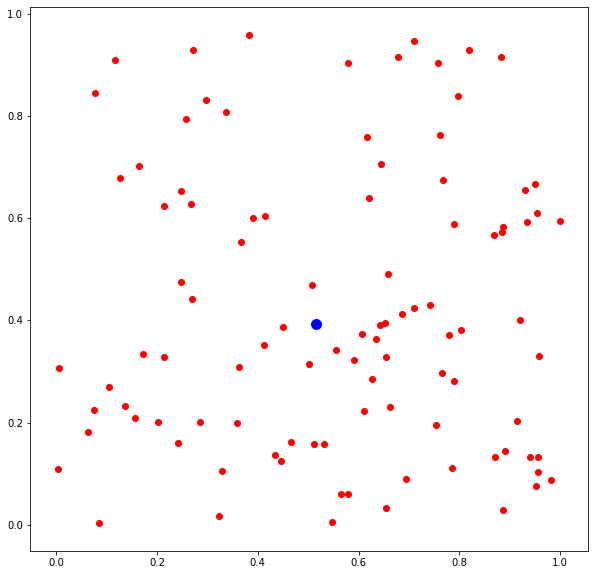

In [7]:
a = np.array(random_data[0]['loc'])
plt.figure(figsize=(10,10))
plt.scatter(a[:,0],a[:,1],c='r')
plt.scatter(random_data[0]['depot'][0],random_data[0]['depot'][1],c='b',s=100)

Red dots are the nodes $n$, and the blue dot corresponds to the depot.

## Solving problem using RL

In order to run the code implement by Bello et. al (2018), I implemented a python class file _'rf1.py'_ that contains all the code needed in order to query the RL model and extract the results.

In [8]:
from rf1_utils import rf1

Now lets init the rf1 class, by passing to it the problem size (100 in this case), the random problem instance generated above, and the vehicle capacity defined for problem with size 100 (50).

In [9]:
#init RL solver
model1 = rf1(size, random_data, CAPACITIES[size])
#query RL model and extract the results
df_rf1_solution, time  = model1.run()
#
df_rf1_solution.head()

,cum_demand,demands,distance,num_nodes,route,vehicle_id
0,50.0,"[1.0, 4.0, 2.0, 7.0, 4.0, 8.0, 7.0, 3.0, 4.0, ...",1.053416,11.0,"[31, 53, 82, 59, 15, 57, 71, 85, 76, 32, 46]",0.0
1,47.0,"[2.0, 2.0, 1.0, 8.0, 3.0, 7.0, 7.0, 7.0, 2.0, ...",1.129440,10.0,"[62, 52, 77, 50, 64, 41, 35, 60, 14, 61]",1.0
2,50.0,"[1.0, 1.0, 2.0, 1.0, 1.0, 4.0, 9.0, 5.0, 9.0, ...",1.327882,13.0,"[80, 25, 44, 72, 30, 90, 16, 37, 75, 78, 5, 23...",2.0
3,46.0,"[3.0, 3.0, 2.0, 1.0, 9.0, 4.0, 7.0, 4.0, 5.0, ...",1.165064,11.0,"[20, 92, 21, 87, 34, 49, 65, 43, 83, 33, 70]",3.0
4,46.0,"[5.0, 8.0, 6.0, 4.0, 2.0, 4.0, 3.0, 1.0, 8.0, ...",1.626623,11.0,"[68, 63, 48, 69, 38, 55, 54, 13, 26, 58, 96]",4.0


Now lets plot the solution

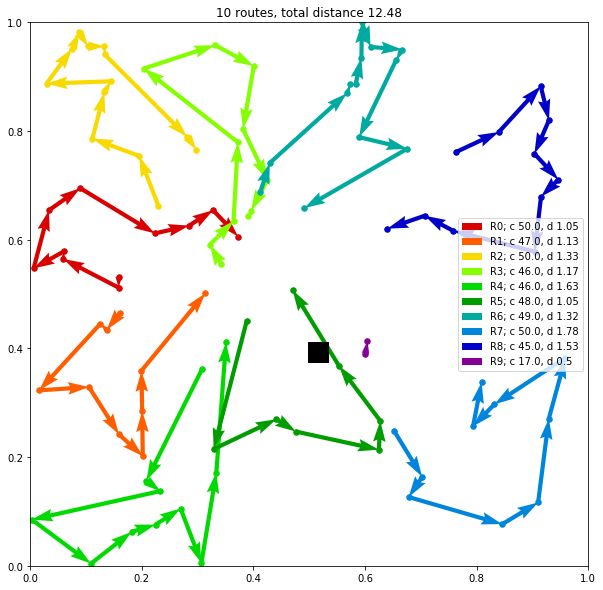

In [10]:
plot_solution(df_rf1_solution, np.insert(np.array(random_data[0]['loc']),0, np.array(random_data[0]['depot']),0),random_data[0]['depot'])

The method bellow extract statistic metrics about the solution provided by the algorithm.

In [11]:
extract_metrics('RL',time, df_rf1_solution)

{'model': 'RL',
 'time': 0.402994,
 'distance': 12.475374400615692,
 'cum_demand_mean': 44.8,
 'distance_mean': 1.248,
 'num_nodes_mean': 10.0,
 'cum_demand_std': 9.942,
 'distance_std': 0.362,
 'num_nodes_std': 3.162,
 'cum_demand_min': 17.0,
 'distance_min': 0.5,
 'num_nodes_min': 2.0,
 'cum_demand_max': 50.0,
 'distance_max': 1.78,
 'num_nodes_max': 13.0}

## Solving problem using OR-Tools ##

Now lets use the OR-Tools to solve the same problem instance $s$. As done with OR-Tools, I've implemented one class in file _'or_tools_utils.py'_ with all the code needed.

In [12]:
from or_tools_utils import *

Preprocess the data in order to fed the cvrp solver

In [13]:
depot, nodes, demands,vehicle_capacities, num_vehicles = preprocess_ortools(int(CAPACITIES[size]),random_data[0])

Solve CVRP using OR-Tools and extract the results

In [14]:
or_cvrp_solver = cvrp_ortools_solver(nodes,num_vehicles,demands,vehicle_capacities)
df_or_solution, timeor = or_cvrp_solver.run()
df_or_solution.head()

,cum_demand,demands,distance,num_nodes,route,vehicle_id
10,50.0,"[3, 4, 1, 1, 1, 1, 9, 4, 7, 4, 1, 1, 5, 1, 7]",1.196883,16.0,"[92, 76, 80, 25, 72, 30, 34, 49, 65, 43, 87, 8...",10.0
11,50.0,"[1, 3, 3, 5, 6, 9, 5, 9, 4, 2, 3]",1.228733,12.0,"[70, 42, 23, 5, 78, 75, 37, 16, 90, 44, 20]",11.0
12,47.0,"[2, 4, 2, 4, 6, 2, 4, 1, 6, 9, 7]",1.220791,12.0,"[29, 24, 7, 9, 17, 6, 81, 56, 36, 66, 79]",12.0
13,50.0,"[8, 4, 4, 1, 4, 8, 3, 7, 7, 4]",1.626793,11.0,"[11, 86, 51, 39, 67, 27, 84, 4, 12, 18]",13.0
14,49.0,"[2, 1, 2, 3, 8, 4, 2, 4, 3, 8, 1, 2, 9]",1.663168,14.0,"[62, 77, 52, 64, 50, 69, 38, 55, 54, 26, 13, 5...",14.0


Plot the solution

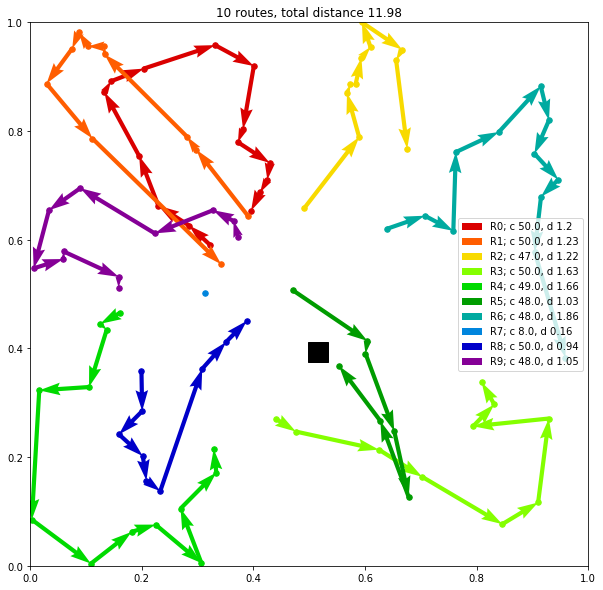

In [15]:
plot_solution(df_or_solution, nodes, depot)

In [16]:
extract_metrics('OR-Tools',timeor,df_or_solution)

{'model': 'OR-Tools',
 'time': 2.455249,
 'distance': 11.9845261,
 'cum_demand_mean': 44.8,
 'distance_mean': 1.198,
 'num_nodes_mean': 11.0,
 'cum_demand_std': 12.977,
 'distance_std': 0.475,
 'num_nodes_std': 3.83,
 'cum_demand_min': 8.0,
 'distance_min': 0.163,
 'num_nodes_min': 2.0,
 'cum_demand_max': 50.0,
 'distance_max': 1.865,
 'num_nodes_max': 16.0}

We can see that for the random problem instance generated, the RL approach gets a better result than the OR-Tools, since the first got a total length of 17.07 and the second 17.67.

# Generate 100 random problems and compare the 2 approaches

In [17]:
num_samples = 100
size = [100,50,20,10]

In this section, I will generate 100 random problem instances for each problem size: 10, 20, 50 and 100. For each problem instanced generated, will be applied both the RL framework and the OR-Tools. The results are stored in _results_ object.

In [18]:
%%time
results = []
if not path.exists('results/results.csv'):
    for _, s in enumerate(size):
        print('size: {}'.format(s))
        random_data2 = generate_data(s, num_samples)
        results_i = []
        for i, d in enumerate(random_data2):  
            #RL
            data_rl = []
            data_rl.append(d)
            model1 = rf1(s, data_rl, CAPACITIES[s])
            df_rf1_solution, time  = model1.run()
            m_rl = extract_metrics('RL',time,df_rf1_solution)
            m_rl['data_id'] = i
            m_rl['size'] = s
            results_i.append(m_rl)

            #OR-Tools
            depot, nodes, demands,vehicle_capacities, num_vehicles = preprocess_ortools(int(CAPACITIES[s]),d)
            or_cvrp_solver = cvrp_ortools_solver(nodes,num_vehicles,demands,vehicle_capacities)
            df_or_solution, timeor = or_cvrp_solver.run()
            m_or = extract_metrics('OR-Tools',timeor,df_or_solution)
            m_or['data_id'] = i
            m_or['size'] = s
            results_i.append(m_or)

        results.append(pd.DataFrame(results_i))
    #merge dfs
    results = pd.concat(results)
    #export result
    results.to_csv('results/results.csv',sep=';')
else: results = pd.read_csv('results/results.csv',sep=';')

Wall time: 25 ms


In [19]:
results

,Unnamed: 0,model,time,distance,cum_demand_mean,distance_mean,num_nodes_mean,cum_demand_std,distance_std,num_nodes_std,cum_demand_min,distance_min,num_nodes_min,cum_demand_max,distance_max,num_nodes_max,data_id,size
0,0,RL,0.160965,14.529257,45.545,1.321,9.091,5.803,0.326,1.640,29.0,0.750,5.0,50.0,1.898,11.0,0,100
1,1,OR-Tools,0.648113,15.762056,45.545,1.433,10.091,5.888,0.519,1.814,30.0,0.631,7.0,50.0,2.466,13.0,0,100
2,2,RL,0.180480,15.830186,45.182,1.439,9.091,10.088,0.476,3.300,16.0,0.303,2.0,50.0,2.085,14.0,1,100
3,3,OR-Tools,0.442898,16.988679,49.700,1.699,11.000,0.675,0.447,1.563,48.0,1.186,9.0,50.0,2.473,14.0,1,100
4,4,RL,0.187001,13.476508,44.909,1.225,9.091,6.818,0.330,2.119,27.0,0.732,5.0,50.0,1.955,12.0,2,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,195,OR-Tools,0.013999,4.355398,15.000,1.452,4.333,3.464,0.200,0.577,11.0,1.221,4.0,17.0,1.568,5.0,97,10
796,196,RL,0.023999,4.632109,16.000,1.544,3.333,1.000,0.674,1.528,15.0,0.766,2.0,17.0,1.937,5.0,98,10
797,197,OR-Tools,0.015002,4.632109,16.000,1.544,4.333,1.000,0.674,1.528,15.0,0.766,3.0,17.0,1.937,6.0,98,10
798,198,RL,0.022001,5.015895,14.500,1.254,2.500,4.041,0.765,1.291,9.0,0.647,1.0,18.0,2.282,4.0,99,10


_results_ have 800 rows: 100 (problem instaces random generated) * 4 (problem sizes tested) * 2 records per problem instance, 1 for the result of the RL and other for OR-Tools.

## RL vs OR-Tools

Lets process the results data, in order to compare how many times the RL approach outperforms the OR-Tools. RL wins when the the total length of the solution is smaller than the solution provided by OR-Tools.

In [20]:
df_analysis = pd.DataFrame()
for _, s in enumerate(size):
    df = results[results['size'] == s]
    
    rl_wins = 0
    or_wins = 0
    for i in range(100):
        i_results = df[df['data_id']==i]
        rl_distance = i_results[i_results['model']=='RL'].distance.values
        or_distance = i_results[i_results['model']=='OR-Tools'].distance.values
        if rl_distance < or_distance:
            rl_wins += 1
        else: or_wins += 1
    r = {'size':s,'algorithm': 'RL','score':rl_wins}
    df_analysis = df_analysis.append(r, ignore_index = True)
    r = {'size':s,'algorithm': 'OR-Tools','score':or_wins}
    df_analysis = df_analysis.append(r, ignore_index = True)

Plot 

Text(0.5, 1, 'RL vs OR-Tools')

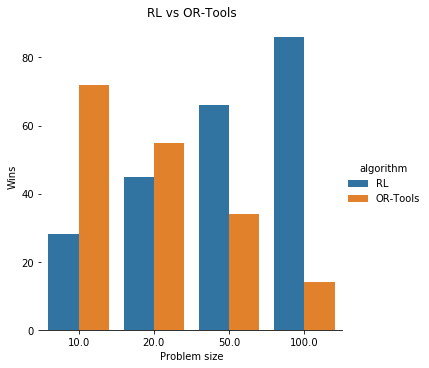

In [21]:
g = sns.catplot(x='size', y = 'score',hue='algorithm', kind='bar', data =df_analysis)
g.set_xlabels('Problem size')
g.set_ylabels("Wins")
g.despine(left=True)
plt.title('RL vs OR-Tools')

As the problem size increases the RL model outperforms the OR-Tools.

## Analyse perfomance in problems of size 100

Get just the results about problem size = 100

In [22]:
results_100 = results[results['size'] == 100]
results_100.head()

,Unnamed: 0,model,time,distance,cum_demand_mean,distance_mean,num_nodes_mean,cum_demand_std,distance_std,num_nodes_std,cum_demand_min,distance_min,num_nodes_min,cum_demand_max,distance_max,num_nodes_max,data_id,size
0,0,RL,0.160965,14.529257,45.545,1.321,9.091,5.803,0.326,1.640,29.0,0.750,5.0,50.0,1.898,11.0,0,100
1,1,OR-Tools,0.648113,15.762056,45.545,1.433,10.091,5.888,0.519,1.814,30.0,0.631,7.0,50.0,2.466,13.0,0,100
2,2,RL,0.180480,15.830186,45.182,1.439,9.091,10.088,0.476,3.300,16.0,0.303,2.0,50.0,2.085,14.0,1,100
3,3,OR-Tools,0.442898,16.988679,49.700,1.699,11.000,0.675,0.447,1.563,48.0,1.186,9.0,50.0,2.473,14.0,1,100
4,4,RL,0.187001,13.476508,44.909,1.225,9.091,6.818,0.330,2.119,27.0,0.732,5.0,50.0,1.955,12.0,2,100


In [23]:
results_100[results_100['model']=='RL'].distance.mean(), results_100[results_100['model']=='OR-Tools'].distance.mean()

(16.960783094502986, 17.480571491)

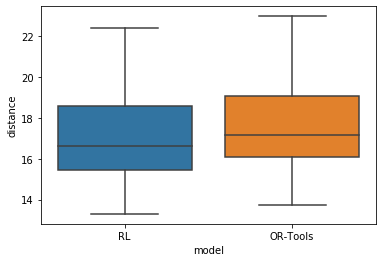

In [24]:
sns.boxplot(y= 'distance',x='model',data = results_100)

We can see in the boxplot above that the mean distance of the solutions of RL are smaller than the ones provided by the OR-Tools (16.96 vs 17.48)

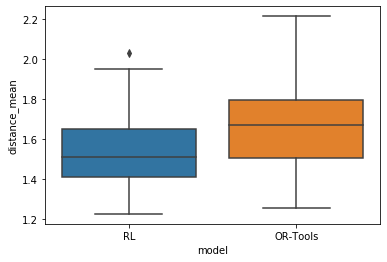

In [25]:
sns.boxplot(y= 'distance_mean',x='model',data = results_100)

The RL tends to create smaller routes for each vehicle, compared to OR-Tools.

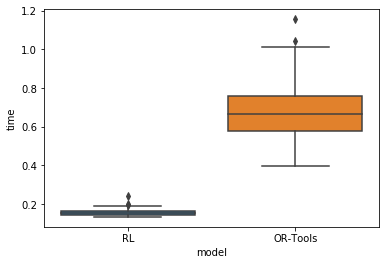

In [26]:
sns.boxplot(y= 'time',x='model',data = results_100)

The RL approach is much more faster in solving the problem.

## Test generability

In this section I will load the RL pretrained model with 100 nodes, and test it with different problem sizes.

In [27]:
num_samples = 100
start_size = 100
sizes = np.arange(start_size - (10*3),start_size + (10*4), 10)
sizes = sizes[sizes != start_size]
sizes

array([ 70,  80,  90, 110, 120, 130])

The RL model will be test with 100 random problem instances, for each size. As done before, each problem solution sampled will be solved  both by the RL method and the OR-Tools, in order to compare the results.

Now lets run this experiment, or load the results from folder.

In [28]:
%%time
results2 = []
if not path.exists('results/results2.csv'):
    for _, s in enumerate(sizes):
        print('size: {}'.format(s))
        random_data2 = generate_data(s, num_samples, CAPACITIES[100])
        results_i = []
        for i, d in enumerate(random_data2):  
            #RL
            data_rl = []
            data_rl.append(d)
            model1 = rf1(100, data_rl, CAPACITIES[100])
            df_rf1_solution, time  = model1.run()
            m_rl = extract_metrics('RL',time,df_rf1_solution)
            m_rl['data_id'] = i
            m_rl['size'] = s
            results_i.append(m_rl)

            #OR-Tools
            #print('\t OR-Tools')
            depot, nodes, demands,vehicle_capacities, num_vehicles = preprocess_ortools(int(CAPACITIES[100]),d)
            or_cvrp_solver = cvrp_ortools_solver(nodes,num_vehicles,demands,vehicle_capacities)
            df_or_solution, timeor = or_cvrp_solver.run()
            m_or = extract_metrics('OR-Tools',timeor,df_or_solution)
            m_or['data_id'] = i
            m_or['size'] = s
            results_i.append(m_or)

        results2.append(pd.DataFrame(results_i))
    results2 = pd.concat(results2)
    results2.to_csv('results/results2.csv',sep=';')
else: results2 = pd.read_csv('results/results2.csv',sep=';')

Wall time: 18.5 ms


Process wins

In [29]:
df_analysis2 = pd.DataFrame()
for _, s in enumerate(sizes):
    df = results2[results2['size'] == s]
    
    rl_wins = 0
    or_wins = 0
    for i in range(100):
        i_results = df[df['data_id']==i]
        rl_distance = i_results[i_results['model']=='RL'].distance.values
        or_distance = i_results[i_results['model']=='OR-Tools'].distance.values
        if rl_distance < or_distance:
            rl_wins += 1
        else: or_wins += 1
    r = {'size':s,'algorithm': 'RL','score':rl_wins}
    df_analysis2 = df_analysis2.append(r, ignore_index = True)
    r = {'size':s,'algorithm': 'OR-Tools','score':or_wins}
    df_analysis2 = df_analysis2.append(r, ignore_index = True)

Plot results

Text(0.5, 1, 'RL (100) C = 50 vs OR-Tools')

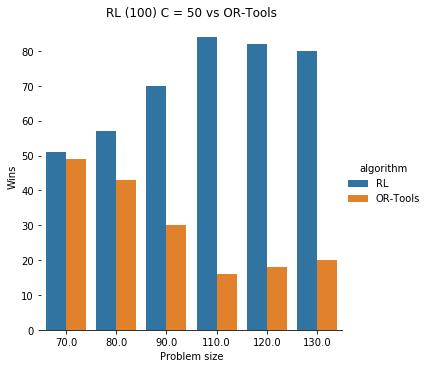

In [30]:
g = sns.catplot(x='size', y = 'score',hue='algorithm', kind='bar', data =df_analysis2)
g.set_xlabels('Problem size')
g.set_ylabels("Wins")
g.despine(left=True)
plt.title('RL (100) C = 50 vs OR-Tools')

We can see that the model generalizes well. A model trained with 100 nodes still gets better results,  in  general,  in  problems  of  size  130  compared  to  the  OR-Tools.  As  the  problem  size decreases, the OR-Tools start to get closer results to the RL. This was expected because we saw above that the OR-Tools outperforms the RL framework in smaller problem sizes.

# References

[1] https://developers.google.com/optimization

[2] https://github.com/wouterkool/attention-learn-to-route
    
[3]  Kool, W., Hoof, H.V., & Welling, M. (2019). Attention, Learn to Solve Routing Problems! ICLR.